# Loading Imagenette using SwiftData

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/sgugger/SwiftCV.git", .branch("master"))' SwiftCV
%install '.package(path: "~/git/SwiftData")' Batcher

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/sgugger/SwiftCV.git", .branch("master"))
		SwiftCV
	.package(path: "~/git/SwiftData")
		Batcher
With SwiftPM flags: []
Working in: /tmp/tmp2vm8rt_8/swift-install
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swiftc: /home/sgugger/anaconda3/lib/libuuid.so

In [2]:
import Path
import TensorFlow
import Batcher
import Foundation

In [3]:
//For image show
import Python
let plt = Python.import("matplotlib.pyplot")

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


This notebook assumes you have [Imagenette](https://github.com/fastai/imagenette) downloaded in the path defined below. Here is the link to [compressed dataset](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz).

In [5]:
let dataPath = Path.home/".fastai"/"data"

## Create a `Batcher`

To create a `Batcher` (which will gather the data lazily using multiprocessing and collate it in batches ready to feed to a model) we need an array of raw items that can fit in memory (in this case, the array of filenames of all images) and a template. The template contains all the details on how to process raw items and collate them in batches, in our case, since we have an image classification problem, there is an `ImageClassificationTemplate` we can use. It only requires two functions: how to open an image and how to label it. 

First, let's get all our image filenames. SwiftData provides a function to easily collect all the files in a directory:

In [6]:
let path = dataPath/"imagenette2"/"train"
let fnames = collectFiles(under: path, recurse: true, filtering: ["jpeg", "jpg"])

### Labels

Before we begin, we need to know how to label our data. Here the labels are given by the names of the parent folder. We gather all possibilities before creating a map from label to index.

In [7]:
let allLabels = fnames.map { $0.parent.basename() }
let labels = Array(Set(allLabels)).sorted()
let labelToInt = Dictionary(uniqueKeysWithValues: labels.enumerated().map{ ($0.element, $0.offset) })
print(labelToInt)

["n03000684": 3, "n03394916": 5, "n03425413": 7, "n03445777": 8, "n03888257": 9, "n03417042": 6, "n03028079": 4, "n02102040": 1, "n01440764": 0, "n02979186": 2]


Note that the labels are in the word2vec format. The correspondence, if needed is the following:
- n01440764='tench',
- n02102040='English springer',
- n02979186='cassette player',
- n03000684='chain saw',
- n03028079='church',
- n03394916='French horn',
- n03417042='garbage truck',
- n03425413='gas pump',
- n03445777='golf ball',
- n03888257='parachute'

### Open images using the `_Raw` backend in S4TF

We can use the methods `_Raw.readFile` and `_Raw.decodeJpeg` to read an image from a filename, then converting to a tensor of ints and resize it to a fixed size (to be able to batch). `_Raw.resizeBilinear` then returns a tensor of floats so we convert it back to ints (another approach would be to leavw it as floats).

In [8]:
func openImage(_ filename: Path) -> Tensor<UInt8> {
    let loadedFile = _Raw.readFile(filename: StringTensor(filename.string))
    let loadedJpeg = _Raw.decodeJpeg(contents: loadedFile, channels: 3, dctMethod: "")
    let image =  _Raw.resizeBilinear(images: Tensor<UInt8>([loadedJpeg]), 
                                     size: Tensor<Int32>([224, 224]))
    return Tensor<UInt8>(image[0])
}

The following function is useful to look at an image:

In [9]:
func showTensorImage<S> (_ img: Tensor<S>) where S: NumpyScalarCompatible {
    let numpyImg = img.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

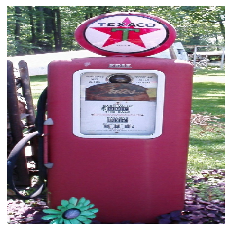

In [10]:
showTensorImage(openImage(fnames[0]))

Once you have functions that can create your inputs and targets, you can use them to create a `basicDataset`. This is just a lazy collection over the `fnames` that will apply the functions to open the images or label them as needed (but don't store everything in memory). The only requirement is that the outputs of the functions `toInput` and `toTarget` are `Tensor`s.

In [11]:
let dataset = basicDataset(
    from: fnames,
    toInput: openImage,
    toTarget: { Tensor<Int32>(Int32(labelToInt[$0.parent.basename()]!)) }
)

This dataset's elements are `TensorPair`s, which is a basic struct representing the tuple (input, target).

In [12]:
print(type(of: dataset[0]))

TensorPair<UInt8, Int32>


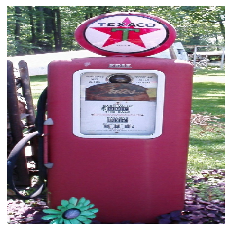

In [13]:
showTensorImage(dataset[0].input)

Images are only loaded when called, as we can check by adding a print statement

In [14]:
func verboseOpenImage(_ filename: Path) -> Tensor<UInt8> {
    print("Opening \(filename.string)")
    return openImage(filename)
}

let verboseDataset = basicDataset(
    from: fnames,
    toInput: verboseOpenImage,
    toTarget: { Tensor<Int32>(Int32(labelToInt[$0.parent.basename()]!)) }
)

Creating the dataset didn't read any of the images. When accessing one element however...

Opening /home/sgugger/.fastai/data/imagenette2/train/n03425413/n03425413_21315.JPEG


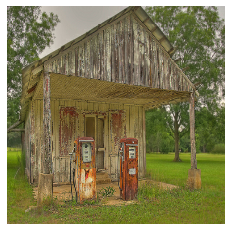

In [15]:
showTensorImage(verboseDataset[2].input)

... we read the image from memory.

From this dataset, we can then easily create a `Batcher`, which gathers samples (the elements of our dataset) and collates them into batches. Since we know how to collate `TensorPair`s, we just have to specify a `dataset` and a `batchSize`.

In [16]:
let batcher = Batcher(on: dataset, batchSize: 256)

In [17]:
let b = batcher.first(where: {_ in true})!

In [18]:
b.input.shape

▿ [256, 224, 224, 3]
  ▿ dimensions : 4 elements
    - 0 : 256
    - 1 : 224
    - 2 : 224
    - 3 : 3


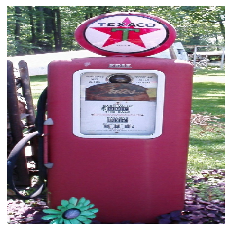

In [19]:
showTensorImage(b.input[0])

We have more options to create a `Batcher`: we can specify a number of `numWorkers` to use parallelism to gather the samples, we can specify if we want to `shuffle` the dataset or not, and if we want to drop the last batch (if it has less elements than `batchSize`) or not.

In [20]:
let batcher = Batcher(on: dataset, batchSize: 256, numWorkers: 8, shuffle: true, dropLast: true)

Then we can time how long it takes to read the whole dataset in batches

In [21]:
import Dispatch

In [22]:
let start = DispatchTime.now()
for b in batcher {
    var s = (b.input.shape, b.target.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

7.235459111


At this stage, our batcher has tensors of bytes as inputs. We can adding the conversion to floats and the normalization using `.lazy.map` and some helpers defined in Utils.

In [23]:
let batcher = Batcher(
    on: dataset, batchSize: 256, numWorkers: 8, shuffle: true, dropLast: true
).lazy.map(toFloat >| imageNetNormalizer.callAsFunction)

In [24]:
let b = batcher.first(where: {_ in true})!

In [25]:
print(b.input.shape, type(of: b))

[256, 224, 224, 3] TensorPair<Float, Int32>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


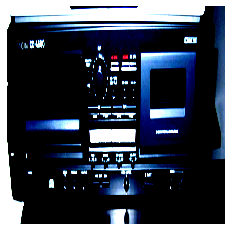

In [26]:
showTensorImage(b.input[0])

We need to denormalize the images to properly show them:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


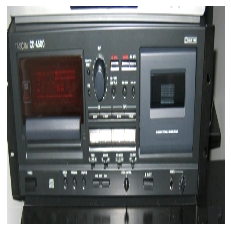

In [27]:
showTensorImage(imageNetNormalizer.denormalize(b).input[0])

Let's look at the timing again with those new operations:

In [28]:
import Dispatch

In [29]:
let start = DispatchTime.now()
for b in batcher {
    var s = (b.input.shape, b.target.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

8.078311578


### Opening images with SwiftCV

Let's now see how efficient we can be by using SwiftCV as a backend instead of `_Raw`.

In [30]:
import SwiftCV

In [31]:
func openCVImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

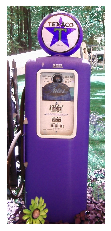

In [32]:
showTensorImage(Tensor<UInt8>(cvMat: openCVImage(fnames[0]))!)

With openCV images, the channels are in BGR instead of RGB so we need to siwtch them:

In [33]:
func BGRToRGB(_ img: Mat) -> Mat {
    return cvtColor(img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

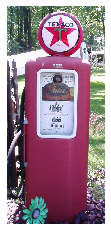

In [34]:
showTensorImage(Tensor<UInt8>(cvMat: BGRToRGB(openCVImage(fnames[0])))!)

We will need to resize our images to be able to batch them

In [35]:
func resize(_ img: Mat, size: Int) -> Mat {
    return resize(img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_LINEAR)
}

And finally we'll need to convert them to a S4TF Tensor:

In [36]:
func cvImgToTensor(_ img: Mat) -> Tensor<UInt8> {
    return Tensor<UInt8>(cvMat: img)!
}

The whole transformation process is defined below, using the composition operator `>|` defined in SwiftData.

In [37]:
let processImage = openCVImage >| BGRToRGB >| { resize($0, size: 224) } >| cvImgToTensor

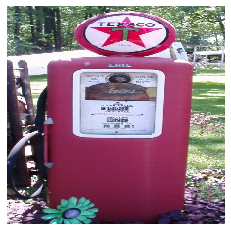

In [38]:
showTensorImage(processImage(fnames[0]))

As before we can define a new dataset and a batcher:

In [39]:
let datasetCV = basicDataset(
    from: fnames,
    toInput: openCVImage >| BGRToRGB >| { resize($0, size: 224) } >| cvImgToTensor,
    toTarget: { Tensor<Int32>(Int32(labelToInt[$0.parent.basename()]!)) }
)

In [40]:
let batcherCV = Batcher(
    on: dataset, batchSize: 256, numWorkers: 8, shuffle: true, dropLast: true
).lazy.map { imageNetNormalizer(toFloat($0)) }

And we can time it against the previous implementation

In [41]:
let start = DispatchTime.now()
for b in batcherCV {
    var s = (b.input.shape, b.target.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

7.970461378


It's slightly slower than before.

## Comparison with `Dataset`

In [56]:
public struct LabeledElement<I: TensorGroup, L: TensorGroup>: TensorGroup {
    public var input: I
    public var target: L    
    
    public init(input: I, target: L) {
        (self.input, self.target) = (input, target)
    }
    
    // Explicit implementation to make this struct work well with LazyTensor.
    // These will be derived automatically in the future.
    public var _tensorHandles: [_AnyTensorHandle] {
        input._tensorHandles + target._tensorHandles
    }
    
    public init<C: RandomAccessCollection>(
        _handles: C
    ) where C.Element: _AnyTensorHandle {
        let xStart = _handles.startIndex
        let xEnd = _handles.index(
            xStart, offsetBy: Int(I._tensorHandleCount))
        self.input = I.init(_handles: _handles[xStart..<xEnd])
        self.target = L.init(_handles: _handles[xEnd..<_handles.endIndex])
    }
}

In [57]:
let dataset = Dataset<LabeledElement<StringTensor, Tensor<Int32>>>(
    elements: LabeledElement(
        input: StringTensor(fnames.map{ $0.string }), 
        target: Tensor<Int32>(fnames.map{ Int32(labelToInt[$0.parent.basename()]!) })
    )
)

In [58]:
func openImage1(_ filename: StringTensor) -> Tensor<UInt8> {
    let loadedFile = _Raw.readFile(filename: filename)
    let loadedJpeg = _Raw.decodeJpeg(contents: loadedFile, channels: 3, dctMethod: "")
    let image =  _Raw.resizeBilinear(images: Tensor<UInt8>([loadedJpeg]), 
                                     size: Tensor<Int32>([224, 224]))
    return Tensor<UInt8>(image[0])
}

In [62]:
var finalDataset = dataset.map(parallelCallCount: 8){ LabeledElement(input: openImage1($0.input), target: $0.target) }.batched(256)

In [63]:
let start = DispatchTime.now()
for b in finalDataset {
    var s = (b.input.shape, b.target.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

27.597456238
